This routine computes the $x,y$ components of the advection of momentum and metric terms given by:

$$ L_U(u) + u v k_y - v^2 k_x $$

$$ L_U(v) + u v k_x - u^2 k_y $$

where

$$L_U(\alpha) = {1\over{\Delta_y}} \delta_x\left[ \overline{\left(\overline{\Delta_y u_x}^y\right)}^{xy} \overline{\alpha}^x\right] +  {1\over{\Delta_x}} \delta_y\left[ \overline{\left(\overline{\Delta_x u_y}^x\right)}^{xy} \overline{\alpha}^y\right]  + \delta_z(w^U\overline{\alpha}^z) $$

$$ k_x = {1\over{\Delta_y}}\delta_x \Delta_y $$

$$ k_y = {1\over{\Delta_x}}\delta_y \Delta_x $$

Comments:
- this routine must be called successively with $k = 1,2,3,...$

- the vertical velocity $w^U$ in U columns is determined by integrating the continuity equation $L(1) = 0$ from the surface down to level k.  In the rigid-lid formulation, the integration starts with $w^U = 0$ at the surface.  In the free-surface formulation, the integration starts with $w^U =$ the area-weighted average of $\partial\eta/\partial t$ at surrounding T points ($\partial\eta/\partial t$ is the time change of the surface height, and satisfies the barotropic continuity equation $\partial\eta/\partial t + \nabla\cdot H {\rm\bf U}=q_w$ where ${\rm\bf U}$ is the barotropic velocity and $q_w$ is the surface fresh water flux.)

In [6]:
import numpy as np
import xarray as xr
import os.path as op

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
datadir = '/data/scratch/takaya/POP_data/'
swotdir = '/swot/SUM05/takaya/POP_data/'

In [8]:
ex = xr.open_dataset(op.join(datadir, 
                             'Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-01-01.nc'),
                    decode_times=False)
mask = ex.KMT > 1
lat = ex.ULAT.where(mask)
lon = ex.ULONG.where(mask)

In [1]:
def mom_advection(years, months, ds):
    
#     t = 0
    for year in years:
        for month in months:
            fname = op.join(datadir, 'Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.%04d-%02d-01.nc'
                                       % (year+46, month))
#             print(fname)
            da = xr.open_dataset(fname, decode_times=False)
            mask = da.KMU > 1
            if month == months[0]:
                u = 1e-2 * da.U1_1.where(mask)[ds[0]::13]
                v = 1e-2 * da.V1_1.where(mask)[ds[0]::13]
            elif month == months[1]:
                u = 1e-2 * da.U1_1.where(mask)[ds[1]::13]
                v = 1e-2 * da.V1_1.where(mask)[ds[1]::13]
            else:
                u = 1e-2 * da.U1_1.where(mask)[ds[-1]::13]
                v = 1e-2 * da.V1_1.where(mask)[ds[-1]::13]
            Nt = u.shape[0]
        
            dx = 1e-2 * da.DXU.where(mask)
            dy = 1e-2 * da.DYU.where(mask)
            uarea_r = 1e4 * da.UAREA.where(mask)**-1
            
            uuw = .25 * (u*dy 
                         + (u*dy).roll(nlon=1).data) + .125 * ((u*dy).roll(nlat=1).data 
                                                               + (u*dy).roll(nlat=1,nlon=1).data
                                                               +(u*dy).roll(nlat=-1).data 
                                                               + (u*dy).roll(nlat=-1,nlon=1).data
                                                              )
            uue = .25 * (u*dy 
                         + (u*dy).roll(nlon=-1).data) + .125 * ((u*dy).roll(nlat=1,nlon=-1).data 
                                                               + (u*dy).roll(nlat=1).data
                                                               + (u*dy).roll(nlat=-1,nlon=-1).data 
                                                               + (u*dy).roll(nlat=-1).data
                                                              )

            vus = .25 * (v*dx 
                         + (v*dx).roll(nlat=1).data) + .125 * ((v*dx).roll(nlon=1).data 
                                                               + (v*dx).roll(nlat=1,nlon=1).data
                                                               + (v*dx).roll(nlon=-1).data 
                                                               + (v*dx).roll(nlon=-1,nlat=1).data
                                                              )
            vun = .25 * (v*dx 
                         + (v*dx).roll(nlat=-1).data) + .125 * ((v*dx).roll(nlon=1,nlat=-1).data 
                                                               + (v*dx).roll(nlon=1).data
                                                               + (v*dx).roll(nlat=-1,nlon=-1).data 
                                                               + (v*dx).roll(nlon=-1).data
                                                              )
                
            cc = vus.roll(nlat=-1).data - vus + uuw.roll(nlon=-1).data - uuw
            
            Luk = .5 * (cc*u + (vus*u).roll(nlat=-1).data - vus*u.roll(nlat=1).data 
                        + (uuw*u).roll(nlon=-1).data - uuw*u.roll(nlon=1).data
                       ) * uarea_r
            Lvk = .5 * (cc*v + (vus*v).roll(nlat=-1).data - vus*v.roll(nlat=1).data 
                        + (uuw*v).roll(nlon=-1).data - uuw*v.roll(nlon=1).data
                       ) * uarea_r
#             if t == 0:
#                 Luk[0].plot(vmin=-1e-6,vmax=1e-6)
#                 plt.show()
            
#             adv_u[t:t+Nt] = Luk.data
#             adv_v[t:t+Nt] = Lvk.data
#             t += Nt
            savename = op.join(swotdir,'surface_data/Momentum_advection_every13days.%04d-%02d.nc'
                              % (year+46, month))
            print(savename)
            LuLv = xr.DataArray(Luk, dims=u.dims, coords=u.coords).to_dataset(name='Lu')
            LuLv['Lv'] = xr.DataArray(Lvk, dims=u.dims, coords=u.coords)
            LuLv.to_netcdf(savename)
            
#     return adv_u, adv_v

In [2]:
Ny=2400; Nx=3600

## winter

In [3]:
years = range(41)
winter = (1,2,3)
ds_JFM = (0,8,6)
days = range(0, 31+28+31, 13)
NtJFM = int(len(years)*len(days))

print(NtJFM)

287


In [9]:
mom_advection(years, winter, ds_JFM)

/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0046-01.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0046-02.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0046-03.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0047-01.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0047-02.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0047-03.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0048-01.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0048-02.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0048-03.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0049-01.nc
/swot/SUM05/takaya/POP_data/surface_data/Momentum_advection_every13days.0049-02.nc


KeyboardInterrupt: 

In [8]:
# LuLv_JFM = xr.DataArray(Lu_JFM, dims=['days','nlat','nlon'],
#                        coords={'days':range(NtJFM),'nlat':range(Ny),'nlon':range(Nx),
#                               'lat':(('nlat','nlon'),lat.data),
#                               'lon':(('nlat','nlon'),lon.data)}).to_dataset(name='Lu')
# LuLv_JFM['Lv'] = xr.DataArray(Lv_JFM, dims=['days','nlat','nlon'],
#                            coords={'days':range(NtJFM),'nlat':range(Ny),'nlon':range(Nx),
#                                   'lat':(('nlat','nlon'),lat.data),
#                                   'lon':(('nlat','nlon'),lon.data)})
# LuLv_JFM.to_netcdf(op.join(swotdir,'surface_data/MomentumAdvection_POPscheme_JFM.nc'))

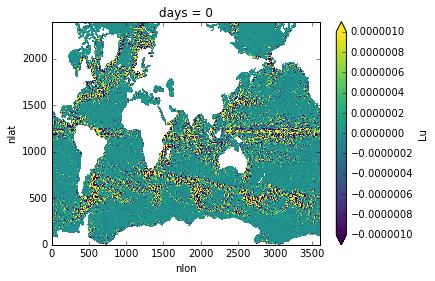

In [9]:
LuLv_JFM.Lu[0].plot(vmin=-1e-6,vmax=1e-6)

## summer

In [21]:
summer = (7,8,9)
ds_JAS = (0,8,3)
days = range(0, 31+31+30, 13)
NtJAS = int(len(years)*len(days))

print(NtJAS)

328


In [ ]:
mom_advection(years, summer, ds_JAS)

In [12]:
LuLv_JAS = xr.DataArray(Lu_JAS, dims=['days','nlat','nlon'],
                       coords={'days':range(NtJAS),'nlat':range(Ny),'nlon':range(Nx),
                              'lat':(('nlat','nlon'),lat.data),
                              'lon':(('nlat','nlon'),lon.data)}).to_dataset(name='Lu')
LuLv_JAS['Lv'] = xr.DataArray(Lv_JAS, dims=['days','nlat','nlon'],
                           coords={'days':range(NtJAS),'nlat':range(Ny),'nlon':range(Nx),
                                  'lat':(('nlat','nlon'),lat.data),
                                  'lon':(('nlat','nlon'),lon.data)})
LuLv_JAS.to_netcdf(op.join(swotdir,'surface_data/MomentumAdvection_POPscheme_JAS.nc'))

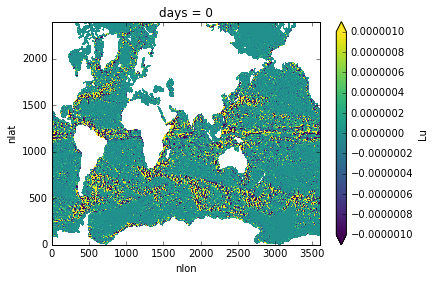

In [13]:
LuLv_JAS.Lu[0].plot(vmin=-1e-6,vmax=1e-6)

## Divide up the data into individual files

In [10]:
dpm_JFM = (3,2,2)
dpm_JAS = (3,2,3)

In [17]:
def divide_LuLv(Nt, dpm, months, season='JFM'):
    time = 0; d = 0
    year = 46
    while time < Nt:
        da = xr.open_dataset(op.join(swotdir,'surface_data/MomentumAdvection_POPscheme_%3s.nc'
                            % season))
        Lu = da.Lu[time:time+dpm[d]]
        Lv = da.Lv[time:time+dpm[d]]
            
        savename = op.join(swotdir,'surface_data/MomentumAdvection_every13days.%04d-%02d.nc'
                          % (year, months[d]))
        print(savename)
        LuLv = Lu.to_dataset(name='Lu')
        LuLv['Lv'] = Lv
        LuLv.to_netcdf(savename)
        
        time += dpm[d]; d += 1;
        if d > 2:
            d = 0
            year += 1

In [ ]:
divide_LuLv(NtJFM, dpm_JFM, winter)

/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0046-01.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0046-02.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0046-03.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0047-01.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0047-02.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0047-03.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0048-01.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0048-02.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0048-03.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0049-01.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0049-02.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0049-03.nc
/swot/SUM05/taka

In [22]:
divide_LuLv(NtJAS, dpm_JAS, summer, season='JAS')

/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0046-07.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0046-08.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0046-09.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0047-07.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0047-08.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0047-09.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0048-07.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0048-08.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0048-09.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0049-07.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0049-08.nc
/swot/SUM05/takaya/POP_data/surface_data/MomentumAdvection_every13days.0049-09.nc
/swot/SUM05/taka